# PPDAI Text Mining

HISTORY
- 20180619: first version
    - simple LSTM
- 20180620:
    - set reduce_lr callback
    - set MAX_SEQUENCE_LENGTH to 100
    - bi-directional model
    - reduce validation data to 5%

In [13]:
%load_ext autoreload
%autoreload 2
from ppdaiutil import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
config = {
    'TRAIN_PATH':'data/train.csv',
    'TEST_PATH':'data/test.csv',
    'QUESTION_PATH' : 'data/question.csv',   
}

** read data **

In [15]:
print('Load files...')
data={
    'qes' : pd.read_csv(config['QUESTION_PATH']),
    'tr' : pd.read_csv(config['TRAIN_PATH']),
    'te' : pd.read_csv(config['TEST_PATH']),
    #'co' : questions['words'],
}
data['co']=data['qes']['words']

Load files...


In [16]:
if False:
    display(data['qes'].head())
    display(data['tr'].head())
    display(data['te'].head())

**1. ID轉成詞語序列or單字序列**

In [17]:
def get_ids(qids):
    ids = []
    for t_ in qids:
        ids.append(int(t_[1:]))
    return np.asarray(ids)

def get_textschars(d):
    all_words = data['qes']['words']
    all_chars = data['qes']['chars']
    q1id, q2id = d['q1'], d['q2']
    id1s, id2s = get_ids(q1id), get_ids(q2id)
    q1_texts = []
    q2_texts = []
    for t_ in zip(id1s, id2s):
        q1_texts.append(all_words[t_[0]])
        q2_texts.append(all_words[t_[1]])
    d['q1_texts'] = q1_texts
    d['q2_texts'] = q2_texts
    
    q1_chars = []
    q2_chars = []
    for t_ in zip(id1s, id2s):
        q1_chars.append(all_chars[t_[0]])
        q2_chars.append(all_chars[t_[1]])
    d['q1_chars'] = q1_chars
    d['q2_chars'] = q2_chars
    

print('Get texts/chars...')
get_textschars(data['tr'])
get_textschars(data['te'])

Get texts/chars...


In [18]:
data['tr'].head()

,label,q1,q2,q1_texts,q2_texts,q1_chars,q2_chars
0,1,Q397345,Q538594,W04465 W04058 W05284 W02916,W18238 W18843 W01490 W09905,L2218 L2568 L0360 L0242 L2218 L0741,L3019 L0104 L0582 L2218 L1861 L1556 L0242
1,0,Q193805,Q699273,W10054 W04476 W09996 W12244 W18103,W18439 W00863 W04259 W00740 W16070,L2376 L2168 L0050 L1187 L0104 L2432 L0902 L014...,L0156 L2452 L1187 L0104 L2459 L2979 L2613 L0449
2,0,Q085471,Q676160,W04346 W17378 W19355 W17926 W14185 W11567 W07863,W14586 W09745 W06017 W09067 W16319,L2323 L1526 L2214 L1132 L2723 L1861 L2249 L050...,L2568 L0971 L1291 L0358 L0037 L2582
3,0,Q189314,Q438123,W17508 W09996 W19662 W17534 W11399 W17057 W182...,W18238 W02357 W06606,L0018 L2321 L1346 L2432 L0902 L1149 L1980 L187...,L3019 L0104 L1104 L1935 L1683 L2495 L2812
4,0,Q267714,Q290126,W13157 W03390 W01952 W05789 W17378 W08714 W13157,W04476 W06606 W00316 W13157,L2271 L1346 L1389 L2932 L0466 L2218 L1971 L221...,L0050 L1187 L0104 L1683 L2495 L2812 L1588 L255...


**2. 序列化**
- tokenizer

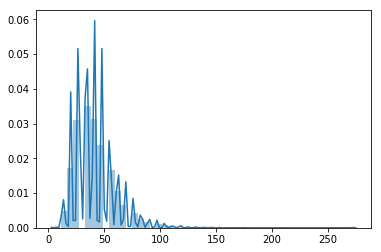

In [19]:

with open('data/word_embed.txt') as f:
    MAX_NB_WORDS = (len(list(f)))

trq1_text=data['tr']['q1_texts'].values
trq2_text=data['tr']['q2_texts'].values
teq1_text=data['te']['q1_texts'].values
teq2_text=data['te']['q2_texts'].values
alltext=np.concatenate([trq1_text, trq2_text, teq1_text, teq2_text])
#MAX_SEQUENCE_LENGTH = max(list(map(lambda x: len(x), alltext))) 
MAX_SEQUENCE_LENGTH=100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS) 
tokenizer.fit_on_texts(alltext) 

sns.distplot(list(map(lambda x: len(x), alltext)))
plt.show()

In [20]:
data['tr']['q1_sequences'] = tokenizer.texts_to_sequences(trq1_text) 
data['tr']['q2_sequences'] = tokenizer.texts_to_sequences(trq2_text) 
data['te']['q1_sequences'] = tokenizer.texts_to_sequences(teq1_text) 
data['te']['q2_sequences'] = tokenizer.texts_to_sequences(teq2_text) 
#data['tr'].head()

In [21]:
word_index = tokenizer.word_index 
print('Found %s unique tokens' % len(word_index)) 

Found 15880 unique tokens


** 3. pad_sequences **

In [22]:
data['trq1_padseq'] = pad_sequences(data['tr']['q1_sequences'], maxlen=MAX_SEQUENCE_LENGTH) 
data['trq2_padseq'] = pad_sequences(data['tr']['q2_sequences'], maxlen=MAX_SEQUENCE_LENGTH) 
data['teq1_padseq'] = pad_sequences(data['te']['q1_sequences'], maxlen=MAX_SEQUENCE_LENGTH) 
data['teq2_padseq'] = pad_sequences(data['te']['q2_sequences'], maxlen=MAX_SEQUENCE_LENGTH) 

** 4. prepare embeddings**

In [23]:

EMBEDDING_FILE='data/word_embed.txt'
EMBEDDING_DIM = 300

embeddings_index = {} 
f = open(EMBEDDING_FILE,"rb") 
for line in f: 
    values = line.split() 
    word = values[0].decode(encoding='utf-8')
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs 
f.close() 

nb_words = len(word_index)+1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) 
for word, i in word_index.items(): 
    word = word.upper()
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector 

    

** prepare training data**

In [24]:
## sample train/validation data

VALIDATION_SPLIT = 0.05
trlen = len(data['trq1_padseq'])
perm = np.random.permutation(trlen)
idx_train = perm[:int(trlen*(1-VALIDATION_SPLIT))] 
idx_val = perm[int(trlen*(1-VALIDATION_SPLIT)):] 

data_trainq1=data['trq1_padseq'][idx_train] 
data_trainq2=data['trq2_padseq'][idx_train] 
data_valq1=data['trq1_padseq'][idx_val] 
data_valq2=data['trq2_padseq'][idx_val] 

labels_train = data['tr']['label'][idx_train] 
labels_val = data['tr']['label'][idx_val] 


date_testq1 = data['teq1_padseq']
date_testq2 = data['teq2_padseq']


In [26]:
MAX_SEQUENCE_LENGTH

100

In [27]:
embedding_layer = Embedding(input_dim=nb_words, output_dim=300, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False) 
num_lstm = 300
num_dense = 256 
rate_drop_lstm = 0.25 
rate_drop_dense = 0.25 
act = 'relu' 


q1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='q1_input') 
q2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='q2_input') 
q1_embseq= embedding_layer(q1_input) 
q2_embseq= embedding_layer(q2_input) 

lstm_layerq1 = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm,return_sequences=True, name='q1_lstm') 
#q1_lstm = lstm_layerq1(q1_embseq) 
q1_lstm = Bidirectional(lstm_layerq1)(q1_embseq)
#q1_drop = Dropout(rate_drop_dense, name='q1_drop')(q1_lstm) 
q1_att = Attention(MAX_SEQUENCE_LENGTH)(q1_lstm)

lstm_layerq2 = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm,return_sequences=True, name='q2_lstm') 
#q2_lstm = lstm_layerq2(q2_embseq) 
q2_lstm = Bidirectional(lstm_layerq2)(q2_embseq)
#q2_drop = Dropout(rate_drop_dense, name='q2_drop')(q2_lstm) 
q2_att = Attention(MAX_SEQUENCE_LENGTH)(q2_lstm)

q1q2_concat = Concatenate(axis=-1,name='q1q2concat')([q1_att,q2_att])
q1q2_concat = Dense(num_dense, activation=act, name='Q_dense')(q1q2_concat) 
q1q2_concat = Dropout(rate_drop_dense, name='Q_drop')(q1q2_concat) 
q1q2_concat = BatchNormalization(name='Q_batchnorm')(q1q2_concat) 
preds = Dense(1, activation='sigmoid', name='Q_output')(q1q2_concat)

model = Model(inputs=[q1_input, q2_input],  outputs=preds) 
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 
print(model.summary()) 
plot_model(model, to_file='model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
q2_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     4764300     q1_input[0][0]                   
                                                                 q2_input[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 100, 600)     1442400     embedding_2[0][0]                
__________

** training **

In [ ]:

bst_model_path = 'model/simple_lstm_best.h5'
print('bst_model_path',bst_model_path) 

early_stopping =EarlyStopping(monitor='val_loss', patience=5) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
checkpointer = ModelCheckpoint(monitor='val_loss',filepath=bst_model_path, verbose=1, save_best_only=True, save_weights_only=True)
callbacks=[reduce_lr, checkpointer]

hist = model.fit([data_trainq1, data_trainq2], labels_train, validation_data=([data_valq1,data_valq2], labels_val), epochs=50, batch_size=256, shuffle=True, callbacks=callbacks) 
bst_val_score = min(hist.history['val_loss']) 
print('\nbst_val_score',bst_val_score)

model.save('model/simple_lstm_final.h5')
ret = model.evaluate([data_valq1,data_valq2], labels_val)
print('final evaluate',ret)

model.load_weights(bst_model_path) 
ret = model.evaluate([data_valq1,data_valq2], labels_val)
print('best evaluate',ret)


plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.ylim((0, 0.5))
plt.show()


    
    
    

bst_model_path model/simple_lstm_best.h5
Train on 241666 samples, validate on 12720 samples
Epoch 1/50
241666/241666 [==============================] - 263s 1ms/step - loss: 0.4007 - acc: 0.8143 - val_loss: 0.3265 - val_acc: 0.8529

Epoch 00001: val_loss improved from inf to 0.32650, saving model to model/simple_lstm_best.h5
Epoch 2/50
241666/241666 [==============================] - 262s 1ms/step - loss: 0.2961 - acc: 0.8704 - val_loss: 0.2804 - val_acc: 0.8769

Epoch 00002: val_loss improved from 0.32650 to 0.28043, saving model to model/simple_lstm_best.h5
Epoch 3/50
241666/241666 [==============================] - 262s 1ms/step - loss: 0.2555 - acc: 0.8902 - val_loss: 0.2516 - val_acc: 0.8910

Epoch 00003: val_loss improved from 0.28043 to 0.25160, saving model to model/simple_lstm_best.h5
Epoch 4/50
241666/241666 [==============================] - 263s 1ms/step - loss: 0.2265 - acc: 0.9035 - val_loss: 0.2508 - val_acc: 0.8962

Epoch 00004: val_loss improved from 0.25160 to 0.25081

12720/12720 [==============================] - 27s 2ms/step
final evaluate [0.43958451479632016, 0.9156446540880503]
12720/12720 [==============================] - 27s 2ms/step
best evaluate [0.23770760890541587, 0.9015723270440251]


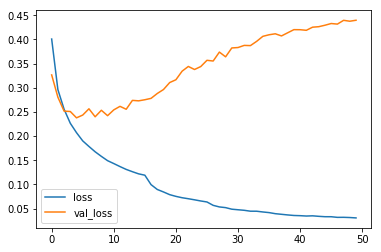

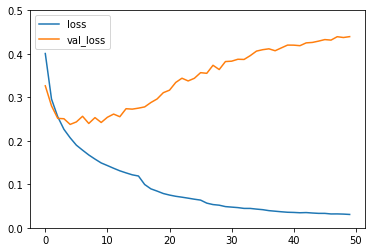

In [30]:
model.load_weights('model/simple_lstm_final.h5')
ret = model.evaluate([data_valq1,data_valq2], labels_val)
print('final evaluate',ret)

model.load_weights(bst_model_path) 
ret = model.evaluate([data_valq1,data_valq2], labels_val)
print('best evaluate',ret)


plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.ylim((0, 0.5))
plt.show()

In [31]:

def make_submission(predict_prob):
    with open('submission.csv', 'w') as file:
        file.write(str('y_pre') + '\n')
        for line in predict_prob:
            file.write(str(line) + '\n')
    file.close()
    
testpred = model.predict([date_testq1, date_testq2], batch_size=1024, verbose=1) 
make_submission(testpred[:, 0])


172956/172956 [==============================] - 48s 276us/step


## TODO: 
~~1. 確認第一版最簡單model的logloss (baseline)~~  
~~2. 參考AP5加入各種callback~~      
3. try importance sampling   
4. try other optimizer (adam...)  
~~5. modify the LSTM model~~  bi-directional model (kaggle的kernel裡面找一下toxic前三名的model)  
~~6. validation data的數量改成3~5%~~  
7. combine word and character  
8. pseudo-labelling  
9. 把句子去頭去尾    
~~10. MAX_SEQUENCE_LENGTH的長度不太合理~~
10. 去除每篇文章都出現的字
